In [1]:
import numpy as np
import pandas as pd
import pickle

df = pd.read_pickle("data/ger_imp.p")

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator

In [3]:
df["recipient_followup_status"] = df["recipient_followup_status"].astype('bool')
df["graft_followup_status"] = df["graft_followup_status"].astype('bool')

Text(0.5, 0, 'time $t$')

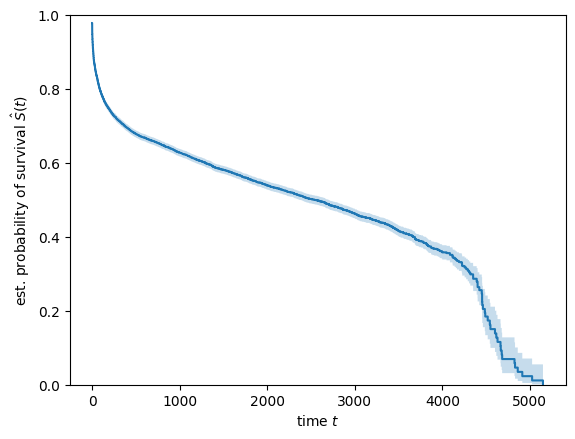

In [4]:
time, survival_prob, conf_int = kaplan_meier_estimator(
    df["graft_followup_status"], df["graft_followup_days"], conf_type="log-log"
)
plt.step(time, survival_prob, where="post")
plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
plt.ylim(0, 1)
plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")

In [5]:
# Columns to split off
cols_to_split = [
    'recipient_followup_status',
    'recipient_followup_days',
    'graft_followup_status',
    'graft_followup_days',
    '1yr_graft',
]

# Create data_y with these columns
data_y = df[cols_to_split].copy()

# Remove those columns from original df
df = df.drop(columns=cols_to_split)

In [6]:
from sksurv.util import Surv

data_y_graft = Surv.from_dataframe(event='graft_followup_status', time='graft_followup_days', data=data_y)
data_y_recip = Surv.from_dataframe(event='recipient_followup_status', time='recipient_followup_days', data=data_y)

In [7]:
from sklearn import set_config
from sksurv.linear_model import CoxPHSurvivalAnalysis

set_config(display="text")  # displays text representation of estimators

In [8]:
estimator = CoxPHSurvivalAnalysis()
estimator.fit(df, data_y_graft)

CoxPHSurvivalAnalysis()

In [9]:
pd.Series(estimator.coef_, index=df.columns)

year                       0.005103
recipient_status          -0.039919
recipient_age              0.013458
recipient_bmi             -0.004202
recipient_sex              0.159596
recipient_blood_type      -0.043315
recipient_rhesus_factor   -0.077373
MELD                       0.031381
cold_ischemia_time         0.000151
donor_age                  0.009088
donor_bmi                  0.001171
donor_sex                 -0.031304
donor_blood_type           0.030574
donor_rhesus_factor       -0.063025
donor_region              -0.022130
donor_drugs               -0.010480
donor_alcohol             -0.006448
donor_alt                  0.000102
donor_ast                 -0.000141
donor_ggt                  0.000568
donor_bili                -0.001955
donor_platelets           -0.000578
donor_sodium              -0.000593
dtype: float64

In [10]:
data_y

,recipient_followup_status,recipient_followup_days,graft_followup_status,graft_followup_days,1yr_graft
0,True,1349.0,True,1349.0,0
1,True,168.0,True,168.0,1
2,False,414.0,False,414.0,0
3,False,2331.0,False,2331.0,0
4,False,2170.0,False,2170.0,0
...,...,...,...,...,...
10359,True,184.0,True,184.0,1
10366,True,358.0,True,358.0,1
10376,True,83.0,True,83.0,1
10381,True,16.0,True,16.0,1


In [11]:
from sksurv.metrics import concordance_index_censored

prediction = estimator.predict(df)
result = concordance_index_censored(data_y["graft_followup_status"], data_y["graft_followup_days"], prediction)
f"{result[0]:.5f}"

'0.62085'

In [12]:
from sksurv.metrics import concordance_index_censored

prediction = estimator.predict(df)
result = concordance_index_censored(data_y["recipient_followup_status"], data_y["recipient_followup_days"], prediction)
f"{result[0]:.5f}"

'0.62451'

In [13]:
import numpy as np


def fit_and_score_features(X, y):
    n_features = X.shape[1]
    scores = np.empty(n_features)
    m = CoxPHSurvivalAnalysis()
    for j in range(n_features):
        Xj = X[:, j : j + 1]
        m.fit(Xj, y)
        scores[j] = m.score(Xj, y)
    return scores


scores = fit_and_score_features(df.values, data_y_graft)
pd.Series(scores, index=df.columns).sort_values(ascending=False)

MELD                       0.606944
donor_age                  0.525978
recipient_age              0.524576
recipient_status           0.519890
donor_ast                  0.515618
donor_ggt                  0.513434
donor_alt                  0.512102
recipient_bmi              0.510648
recipient_sex              0.509773
donor_region               0.509603
donor_rhesus_factor        0.507212
donor_sex                  0.505971
donor_bili                 0.504901
recipient_rhesus_factor    0.502671
recipient_blood_type       0.501906
donor_drugs                0.501670
donor_sodium               0.500877
donor_blood_type           0.500628
donor_platelets            0.499835
donor_bmi                  0.499470
donor_alcohol              0.499380
year                       0.497038
cold_ischemia_time         0.494175
dtype: float64

# Random survival forest (RSF)

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

from sklearn import set_config
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

# from sksurv.datasets import load_gbsg2
from sksurv.ensemble import RandomSurvivalForest
from sksurv.preprocessing import OneHotEncoder

set_config(display="text")  # displays text representation of estimators

In [15]:
random_state = 20

X_train, X_test, y_train, y_test = train_test_split(df, data_y_graft, test_size=0.25, random_state=random_state)

In [16]:
rsf = RandomSurvivalForest(
    n_estimators=1000, min_samples_split=10, min_samples_leaf=15, n_jobs=-1, random_state=random_state
)
rsf.fit(X_train, y_train)

RandomSurvivalForest(min_samples_leaf=15, min_samples_split=10,
                     n_estimators=1000, n_jobs=-1, random_state=20)

In [17]:
c_index = rsf.score(X_test, y_test)
f"{c_index:.5f}"

'0.64520'

In [18]:
X_test_sorted = X_test.sort_values(by=["MELD", "donor_age"])
X_test_sel = pd.concat((X_test_sorted.head(5), X_test_sorted.tail(5)))

X_test_sel

,year,recipient_status,recipient_age,recipient_bmi,recipient_sex,recipient_blood_type,recipient_rhesus_factor,MELD,cold_ischemia_time,donor_age,...,donor_rhesus_factor,donor_region,donor_drugs,donor_alcohol,donor_alt,donor_ast,donor_ggt,donor_bili,donor_platelets,donor_sodium
5733,2014,2,18.586301,16.135394,1,2,1,6.0,615.0,18.624658,...,1,7,0,0,133.0,177.0,82.0,13.0,140.0,147.0
5405,2007,1,49.627397,35.379813,0,1,0,6.0,601.0,19.400000,...,1,3,0,0,25.0,75.0,19.0,22.0,78.0,160.0
9871,2017,2,62.843836,18.986591,0,4,1,6.0,635.0,19.600000,...,1,4,0,0,138.0,179.0,92.0,10.0,212.0,146.0
9635,2018,2,45.578082,20.415225,0,1,1,6.0,540.0,22.249315,...,1,5,0,0,32.0,95.0,82.0,49.0,156.0,139.0
7651,2009,2,40.983562,24.218750,0,2,1,6.0,596.0,26.087671,...,1,5,0,0,93.0,113.0,60.0,20.0,239.0,145.0
9065,2011,2,64.254795,23.120624,1,4,1,40.0,624.0,77.926027,...,1,4,0,0,41.0,67.0,49.0,16.0,160.0,139.0
5672,2011,2,37.561644,23.233456,0,1,0,40.0,588.0,77.953425,...,1,6,0,0,20.0,37.0,20.0,6.0,182.0,149.0
3653,2014,2,57.517808,26.346494,0,4,1,40.0,565.0,78.046575,...,1,5,0,0,14.0,21.0,20.0,16.0,194.0,139.0
2741,2012,2,56.745205,22.206331,0,1,1,40.0,580.0,78.336986,...,1,1,0,0,20.0,25.0,29.0,14.0,92.0,139.0
4244,2009,2,43.572603,21.513859,0,1,1,40.0,630.0,84.621918,...,1,7,0,0,17.0,25.0,8.0,8.0,229.0,144.0


In [19]:
pd.Series(rsf.predict(X_test_sel))

0     493.549783
1     411.210791
2     561.633746
3     551.802315
4     229.445018
5    1288.142329
6    1108.591180
7    1071.784866
8    1235.646772
9    1123.532495
dtype: float64

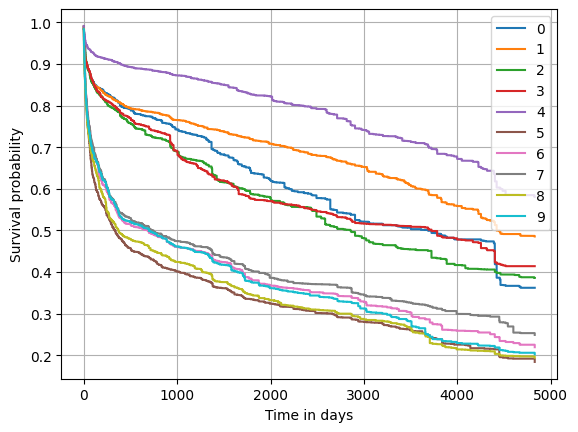

In [20]:
surv = rsf.predict_survival_function(X_test_sel, return_array=True)

for i, s in enumerate(surv):
    plt.step(rsf.unique_times_, s, where="post", label=str(i))
plt.ylabel("Survival probability")
plt.xlabel("Time in days")
plt.legend()
plt.grid(True)

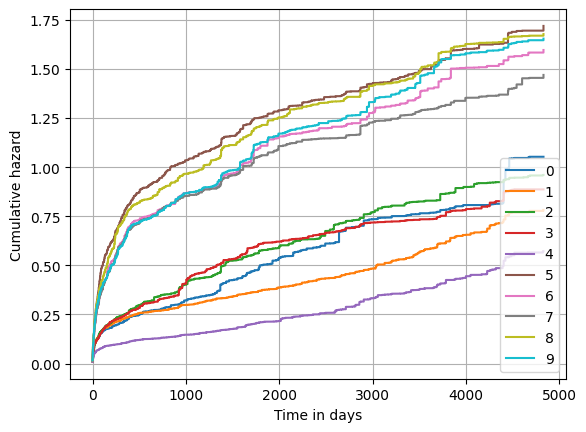

In [21]:
surv = rsf.predict_cumulative_hazard_function(X_test_sel, return_array=True)

for i, s in enumerate(surv):
    plt.step(rsf.unique_times_, s, where="post", label=str(i))
plt.ylabel("Cumulative hazard")
plt.xlabel("Time in days")
plt.legend()
plt.grid(True)

# Gradient Boosted Models

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

%matplotlib inline

# from sksurv.datasets import load_breast_cancer
from sksurv.ensemble import ComponentwiseGradientBoostingSurvivalAnalysis, GradientBoostingSurvivalAnalysis
from sksurv.preprocessing import OneHotEncoder

In [35]:
est_cph_tree = GradientBoostingSurvivalAnalysis(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
est_cph_tree.fit(X_train, y_train)
cindex = est_cph_tree.score(X_test, y_test)
print(round(cindex, 5))

0.64243
